## TODO
* Re-write for more than two classes
* First fix FI, then FM
* Monte Carlo sim to test all permutations; OR:
* Increment steps based on PDF, with each step having an equal prob.
* Jim's suggestion: try replacing EM with land, in addition to water, as I have it now
* Add randomization/monte-carlo into bins- instead of just using mean values (i.e. for size bins, or for FLUX_STEP in senstivity)
* For typical EM fraction: use regional sub-binning instead of UAVSAR footprint 
* Use typical regional values for EM fluxes, the way I use a regional LSD and inun fraction
* install add-ons: git, variable inspector: first install node.js, npm, jupyterlab-git
* Find a plugin to make matplotlib plots interactive like when they appear in sep. window
* make dimensionless version
* (contour plot: fill in color between lines) DONE
* Add size binning: ingest lake size distrib DONE

## Description
This script takes as input the landscape inundation fraction, the emergent macrophyte fraction (fraction of all inundated areas), and flux values for these fractions. It then iterates over probable ranges and plots the total flux's sensitivities to these values, Normalized by area.


| Name  | Description | Value |
|---      |---                |---       |
| INPUTS |
FLUXES | Dictionary of flux values by class	<mg CH4 / m2/ day>| OW: (0, 166); EM: (77, 5800)
FRACTION:IN_TOTAL | Fraction inundated: Range for open water and emergent macrophyte area divided by total landscape area | (10, 38)
FRACTION:EM | Fraction EMERGENT macrophyte: Range for emergent macrophyte area / open water area | (2, 60)
FRACTION:  ... | ...
FRACTION_STEPS | Number of steps for each landcover type (range / increment) |
FRACTION_RATIO | Number of steps for each landcover type (range / increment) |
FLUX_STEPS | Number of steps for flux (range / increment) |


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
# import scipy.ndimage as ndi 
from scipy.io import loadmat
from scipy.stats import binned_statistic
import pandas as pd
from uncertainties import unumpy, umath
import qgrid
qgrid.enable() #enable interactive pandas dataframes
# %matplotlib inline

In [3]:
## qgrid parameters
# for help, see https://qgrid.readthedocs.io/en/latest/ or https://github.com/quantopian/qgrid

## set defaults
grid_options = {
        # SlickGrid options
        'fullWidthRows': True, # True
        'syncColumnCellResize': True,
        'forceFitColumns': False, #True
        'defaultColumnWidth': 100, # 150
        'rowHeight': 28,
        'enableColumnReorder': True,
        'enableTextSelectionOnCells': True,
        'editable': True,
        'autoEdit': False,
        'explicitInitialization': True,

        # Qgrid options
        'maxVisibleRows': 10,
        'minVisibleRows': 4,
        'sortable': True,
        'filterable': True,
        'highlightSelectedCell': True,
        'highlightSelectedRow': True
    }

col_options = {
    # SlickGrid column options
    'defaultSortAsc': True,
    'maxWidth': None, # None,
    'minWidth': 30, #30
    'resizable': True,
    'sortable': True,
    'toolTip': "",
    'width': None, # None

    # Qgrid column options
    'editable': True,
}
qgrid.set_defaults(grid_options=grid_options, column_options=col_options)

### Inputs

In [4]:
# fluxes={'OW': 100,
#        'GW': 300,
#        'SW': 200}

FRACTION={
    'IN_TOTAL':(
    (22, 31),
    (10,16),
    (27, 30),
    (37.4, 37.6),
    (10, 37.6)), # Default Fraction Inundated; From Run 35
    'EM':((35, 58),
     (42, 60),
     (12, 21),
     (2, 2.5),
     (0, 100)) #(2, 30) # Default Fraction macrophyte: From Run 35 (range: 2:60)
}
FLUXES={
    'OW': (0, 166), # Open water; From range in: Burger et al 2016	Biogeosciences | Superceded if using LSD
    'EM': (77, 2000), # (77, 3000) #(77, 380)  # Emergent macrophyte; From mean (max = 5800) in: Burger et al 2016	Biogeosciences
    'RATIO': (0, 200) # based on second and third- highest values of ~170x
}
    # Sensitivity raster dimensions
FRACTION_STEPS=100 # 40
FLUX_STEPS=100 # 40
SITES=('PAD','YFB','YKN','DAR','All') #short names for sites
SITES_LSD = (9,2,7,7,0) # numbers as givin in Lake Size Distribution files
# REGION=0 # Set to -1 if using default; 0=PAD

# LAT=59 # latitude, in degrees (PAD=59)

### Lake size distribution inputs

Labels:
    'All'
    'Sagavanirktok River'
    'Yukon Flats Basin'
    'Old Crow Flats'
    'Mackenzie River Delta'
    'Mackenzie River Valley'
    'Canadian Shield Margin'
    'Canadian Shield'
    'Slave River'
    'Peace-Athabasca Delta'
    'Athabasca River'
    'Prairie Potholes North'
    'Prairie Potholes South'
    'Tuktoyaktuk Peninsula'
    []
    []
    []
    []
    []
    []
    []
    'Prairie pothole regions'
    'Canadian Shield'
    'Thermokarst regions'
    'Arctic-boreal wetlands'
    'Lowland river valleys'

In [5]:
lsd_pth='/mnt/d/GoogleDrive/Research/Lake distributions/savedData/fitting_data_regional_4_det.mat' # these directories hold the final version of data used for 2019 paper
lsd_labels_pth='/mnt/d/GoogleDrive/Research/Lake distributions/regionLabels4.mat'

### Size binning data from Holgerson and Raymond 2016

In [6]:
BIN_EDGES=np.array([0, 0.001, 0.01, 0.1, 1, 10, 100, 1000000]) # <km2>
# BIN_EDGES=np.array([0.001, 0.01, 0.1, 1, 10, 100, 10000000]) * 1000000 # <km2> * 1000000 = <m2>
BIN_FLUXES=np.array([2.28, 0.65, 0.28, 0.16,  0.12, 0.10, 0.06])*16.043 # <mmolC (in CH4)/m2/d> * 16.043 = <mg CH4/m2/d>
len(BIN_FLUXES)

7

### Load data

In [7]:
fused_regional=loadmat(lsd_pth, variable_names='Fused_regional', squeeze_me=True)

##############
# for area for each region, see: D:\GoogleDrive\Research\Lake distributions\savedData\out
##############

### Create sensitivity raster

In [8]:
SENSITIVITY={}
FRACTION_POSTINGS={}
FLUX_POSTINGS={}
for si, s in enumerate(SITES):
    print('\nSite: {}'.format(s))
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    SENSITIVITY[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    # lsd_tmp=lsd # init
    FRACTION_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys():
        FLUX_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS)
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum()
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        ##############################################
             # toggle if not using LSD
    #     ow_flux_mean=np.mean(FLUX_POSTINGS['OW'])
        ##############################################
            # toggle if using LSD | with lakes changing bins # Results in higher water flux in highest EM bin bc more of the lakes are now small (unrealistic)
    #     lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='sum', bins=BIN_EDGES) # could also use np.digitize
    #     ow_flux_mean=np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd_tmp.sum()
    #     print(f'EM fraction: {FRACTION_POSTINGS[i]:0.2f}%\t| Total W area in first bin: \
    #         {lsd_tmp_vals.statistic[0]:.2f}\t| Total W area: {np.sum(lsd_tmp_vals.statistic):.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
            # toggle if using LSD | with lakes NOT changing bins # Results in lower water flux in highest EM bin
        print(f'EM fraction: {FRACTION_POSTINGS[s][i]:0.2f}%\t| Total W area in first bin: \
            {lsd_vals.statistic[0]*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W area: \
            {np.sum(lsd_vals.statistic)*(100- FRACTION_POSTINGS[s][i])/100:.2f}\t| Total W flux: {((100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
        for j in range(FLUX_STEPS):
            # each cell = <region's inundation fraction> * (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            SENSITIVITY[s][i,j] = np.mean(FRACTION['IN_TOTAL'][si]) / 100 * (FRACTION_POSTINGS[s][i] * FLUX_POSTINGS['EM'][j] + # use median? # note: hard-coded for just two classes: OW and EM
                                (100- FRACTION_POSTINGS[s][i]) * ow_flux_mean) / 100
        


Site: PAD
Open water flux used: 1.36 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.40	| Total W area: 186.62

EM fraction: 35.00%	| Total W area in first bin:             0.26	| Total W area:             121.30	| Total W flux: 0.89
EM fraction: 35.23%	| Total W area in first bin:             0.26	| Total W area:             120.87	| Total W flux: 0.88
EM fraction: 35.46%	| Total W area in first bin:             0.26	| Total W area:             120.43	| Total W flux: 0.88
EM fraction: 35.70%	| Total W area in first bin:             0.26	| Total W area:             120.00	| Total W flux: 0.88
EM fraction: 35.93%	| Total W area in first bin:             0.26	| Total W area:             119.57	| Total W flux: 0.87
EM fraction: 36.16%	| Total W area in first bin:             0.26	| Total W area:             119.13	| Total W flux: 0.87
EM fraction: 36.39%	| Total W area in first bin:             0.26	| Total W area:             118.70	| Total W flux: 0.87


## Make contour plots

NameError: name 'ndi' is not defined

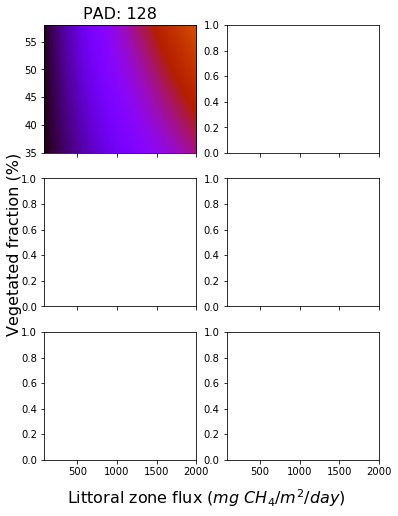

In [9]:
## Raster plot
# plt.xticks(FLUX_POSTINGS[0:4:])
# plt.yticks(FRACTION_POSTINGS[0:4:])
f=16 # font size
# ax=np.zeros((3,2))
shape=(3,2)
fig, ax = plt.subplots(shape[0], shape[1], sharex=True, figsize=(6,8))
for si, s in enumerate(SITES):
    idx=np.unravel_index(si, shape)
    p=ax[idx].imshow(SENSITIVITY[s], origin='lower', aspect='auto', cmap='gnuplot', vmin=0, vmax=450, extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))
#     ax[idx].set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f)
#     ax[idx].set_ylabel('Vegetated fraction (%)', fontsize=f)
    fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
    fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax[idx].set(xlabel="Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ylabel='Vegetated fraction (%)', fontsize=f)
#     ax[idx].set_title('{} | Total flux ($mg\ CH_4 / m^2 /day$)'.format(s), fontsize=f)
    ax[idx].set_title(f'{s}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
#     ax[idx].colorbar()
#     fig.tight_layout()
#     axes=plt.gca()
    # plt.rcParams({'dpi':300})
    # axes.set_xlim(FLUXES['EM'])
    # axes.set_ylim(FRACTION['EM'])
    # plt.xticks(FLUX_POSTINGS[0:4:])
    # plt.yticks(FRACTION_POSTINGS[0:4:])

    ## calculate median:
    cy, cx = ndi.center_of_mass(SENSITIVITY[s])

    ## report mean value:
#     print('Mean flux: \t{:.1f} mg CH_4/m^2/day'.format(np.mean(SENSITIVITY[s])))
#     print('\'Median\' flux: \t{:.1f} mg CH_4/m^2/day'.format(SENSITIVITY[s][cy.astype(int),cx.astype(int)])) # only equal to median if each step size is of equal prob.
#     print('''\nINPUTS:
#     FRACTION:\t{}
#     FLUXES:\t\t{}
#     '''.format(FRACTION, FLUXES))

    # common plot options
fig.suptitle('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f+3)
ax[shape[0]-1, shape[1]-1].axis('off')
# ax[shape[0]-1, shape[1]-1].colorbar()
cbaxes = fig.add_axes([0.6, 0.2, 0.28, 0.03]) 
fig.colorbar(p, cax=cbaxes, orientation='horizontal')
# fig.colorbar(p, ax=ax[shape[0]-1, shape[1]-1], orientation='horizontal')
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRaster.pdf'
plt.savefig(figPth, dpi=300)
print('Saved fig to:\t{}'.format(figPth))

In [ ]:
## Make contour plot
## TODO: fill in between lines
## from https://matplotlib.org/examples/pylab_examples/contour_label_demo.html

    # I/O
num_contours=10

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

##
plt.figure()

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(shape[0], shape[1], sharex=True, figsize=(6,8))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in enumerate(SITES):
    idx=np.unravel_index(si, shape)
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax[idx].contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax[idx].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
#     ax[idx].set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
#     ax[idx].set_ylabel('Vegetated fraction (%)', fontsize=f)
    fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
    fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
    ax[idx].set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
#     plt.tight_layout()
    
    # plot format
plt.suptitle('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f)
ax[shape[0]-1, shape[1]-1].axis('off')

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.pdf'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContours.jpg'
plt.savefig(figPth, dpi=300)
print('Saved fig to:\t{}'.format(figPth))

## Add lit values as pts with error bars

In [44]:
## Add fluxes from lit
lit_pth='data/Flux_synthesis.xlsx'
df=pd.read_excel(lit_pth)

## exclude extra rows with no data
df=df[~np.isnan( df['flux_to_plot_[mgCH4_m2_day]'])]

## exclude rows flagged to exclude
df.drop(index=df.query("Exclude==1").index, inplace=True)
df.drop(columns='Exclude', inplace=True)

## remove unecessary columns
df.drop(['Typical flux (gC/m2/yr)', 'flux_to_plot_[mmolCH4_m2_day]', 'confidence_int_min_[mmolCH4_m2_day]', 
        'confidence_int_max_[mmolCH4_m2_day]', 'confidence_int_min_[mmolCH4_m2_day]', 'confidence_int_max_[mmolCH4_m2_day]'], axis=1, inplace=True)

## first set nans to zero
df.loc[np.isnan(df['confidence_int_max_[mgCH4_m2_day]']), ('confidence_int_max_[mgCH4_m2_day]', 'confidence_int_min_[mgCH4_m2_day]')]= \
    0

## fill empty vals
df.loc[np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0), 'confidence_int_min_[mgCH4_m2_day]']= \
    np.mean(df.loc[~np.isin(df['confidence_int_min_[mgCH4_m2_day]'], 0), 'confidence_int_min_[mgCH4_m2_day]'])
df.loc[np.isin(df['confidence_int_max_[mgCH4_m2_day]'], 0), 'confidence_int_max_[mgCH4_m2_day]']= \
    np.mean(df.loc[~np.isin(df['confidence_int_max_[mgCH4_m2_day]'], 0), 'confidence_int_max_[mgCH4_m2_day]'])

df.loc[np.isnan(df['EM_percent']), 'EM_percent_conf_in_min']=np.nan # 50 # arbitrary value for lit fluxes CI w no EM % data
df.loc[np.isnan(df['EM_percent']), 'EM_percent_conf_in_max']=np.nan # 50 # arbitrary value for lit fluxes CI w no EM % data
df.loc[np.isnan(df['EM_percent']), 'EM_percent']=np.nan # 50 # arbitrary value for lit fluxes w no EM % data

df.loc[np.isnan(df['EM_percent_conf_in_min']), 'EM_percent_conf_in_min']=np.minimum(df.loc[np.isnan(df['EM_percent_conf_in_min']), 'EM_percent'], 5) # arbitrary value, placeholder for now #  | np.isin(df['EM_percent_conf_in_min'], 0)
df.loc[np.isnan(df['EM_percent_conf_in_max']), 'EM_percent_conf_in_max']=np.minimum(100-df.loc[np.isnan(df['EM_percent_conf_in_max']), 'EM_percent'], 5) # arbitrary value, placeholder for now


## Save copy for ratio plot
dfr=df.copy()

## drop/pop OW vals
idx=df.query('Surface == "OW"').index
df.drop(index=idx, inplace=True)

In [45]:
np.unique(df['Citation'])

array(['Bergström et al. 2007', 'Burger et al 2016',
       'DelSontro et al. 2016', 'Dove at al 1999', 'Juutinen et al. 2003',
       'Kankaala et al. 2005', 'Kankaala et al. 2013',
       'Larmola et al 2004', 'Ribaudo et al. 2012',
       'Smith and Lewis, 1992', 'TBD'], dtype=object)

In [46]:
## Create variables for plots
## assign: lit vals
FLUXES_LIT=df[df['Orig_paper']!='above2_team' ]['flux_to_plot_[mgCH4_m2_day]'] # use for sens. plot
FRACTION_LIT=df[df['Orig_paper']!='above2_team' ]['EM_percent'] # use for sens. plot
FLUXES_LIT_CI=np.array([df[df['Orig_paper']!='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], df[df['Orig_paper']!='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_LIT_CI=np.array([df[df['Orig_paper']!='above2_team' ]['EM_percent_conf_in_min'],df[df['Orig_paper']!='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot

## assign: field vals
FLUXES_FIELD=df[df['Orig_paper']=='above2_team' ]['flux_to_plot_[mgCH4_m2_day]'] # use for sens. plot
FRACTION_FIELD=df[df['Orig_paper']=='above2_team' ]['EM_percent'] # use for sens. plot
FLUXES_FIELD_CI=np.array([df[df['Orig_paper']=='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], df[df['Orig_paper']=='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_FIELD_CI=np.array([df[df['Orig_paper']=='above2_team' ]['EM_percent_conf_in_min'],df[df['Orig_paper']=='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot

## view
df
# df
# df.describe()

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [47]:
## Single contour plot
%matplotlib widget
f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY['All']), 11) #10
num_contours = np.linspace(2, 250, 15) #10

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(sharex=True, figsize=(4,4))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_POSTINGS[s]
    X=FLUX_POSTINGS['EM']
    Z=SENSITIVITY[s]
    
    # Basic contour plot
    CS = ax.contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=500,
        extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.set_xlabel("Littoral zone flux ($mg\ CH_4 / m^2 /day$)", fontsize=f+2)
    ax.set_ylabel('Vegetated fraction (%)', fontsize=f)
#     fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
#     fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax.set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY[s]):0.0f}', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
ax.errorbar(FLUXES_LIT, FRACTION_LIT, FRACTION_LIT_CI,FLUXES_LIT_CI, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
ax.errorbar(FLUXES_FIELD, FRACTION_FIELD, FRACTION_FIELD_CI,FLUXES_FIELD_CI, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## title
plt.title('Water surface flux contribution ($mg\ CH_4 / m^2 /day$)', fontsize=f-2)

## legend
plt.legend(['Published data', 'Field data'], loc='best')

## set window
ax.set_xlim(0, 1000)

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.jpg'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.pdf'
plt.savefig(figPth, dpi=300)

print('Saved fig to:\t{}'.format(figPth))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursErrors.pdf


## Plot values as ratios

In [173]:
## workflow: join based on lake name in order to manipulate data frame to include OW - EM pairs
dfr_em=dfr.set_index('Lake').query("Surface != 'OW' ") # data frame ratio em
dfr_ow=dfr.set_index('Lake').query("Surface == 'OW' ") # data frame ratio em
# dfr_ow.columns

## temp join to save text fields # remove Top\paper bc I'm only taking first value of it and Surface bc it is being joined as well
text= dfr_ow.select_dtypes('object').drop(labels=['Topic\Paper', 'Surface'], axis=1).groupby('Lake').first() #.drop(labels='Topic\Paper', axis=1).drop_duplicates() #.groupby('Lake')
# text
# dfr_em.loc[:, ('flux_to_plot_[mgCH4_m2_day]', 'Surface')]

## aggregate dfr_em to average all vegetation types per lake
dfr_em=pd.DataFrame(dfr_em.reset_index().groupby('Lake').mean())
dfr_ow=pd.DataFrame(dfr_ow.reset_index().groupby('Lake').mean())
dfr_ow.index
# text.index
# text.columns
# text.query("Lake == 'Canvasback Lake'")
dfr_em.loc[:, 'flux_to_plot_[mgCH4_m2_day]']

## only keep columns I need (don't use EM % from OW entries - some may be blank)
dfr_ow =dfr_ow.loc[:, ('flux_to_plot_[mgCH4_m2_day]', 'confidence_int_min_[mgCH4_m2_day]', 'confidence_int_max_[mgCH4_m2_day]' )]

## join text back in
dfr_ow=dfr_ow.join(text, 'Lake', how='left')
dfr_ow.index
dfr_ow.loc[:, ('Citation', 'Orig_paper')]

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [174]:
## join
dfr_j= dfr_em.join(dfr_ow, 'Lake', lsuffix='_em', rsuffix='_ow') # data frame ratio join
         # .loc[:, ('flux_to_plot_[mgCH4_m2_day]', 'confidence_int_min_[mgCH4_m2_day]', confidence_int_max_[mgCH4_m2_day]')]
dfr_j.columns
# dfr_em.Lake.count()
# dfr_em
dfr_j['confidence_int_max_[mgCH4_m2_day]_ow']
dfr_j.columns
dfr_j.index
np.unique(df['Citation'])
# np.unique(dfr_j['Citation'])
# dfr_j.loc[:, ('Citation', 'Orig_paper')]
# dfr_j
# dfr_j.head()
# len(dfr_ow)
# text
# dfr_ow

array(['Bergström et al. 2007', 'Burger et al 2016',
       'DelSontro et al. 2016', 'Dove at al 1999', 'Juutinen et al. 2003',
       'Kankaala et al. 2005', 'Kankaala et al. 2013',
       'Larmola et al 2004', 'Ribaudo et al. 2012',
       'Smith and Lewis, 1992', 'TBD'], dtype=object)

In [175]:
## Manually check which lakes are missing OW or EM vals:

missing_val_idx=(np.isnan(dfr_j['flux_to_plot_[mgCH4_m2_day]_ow'])) | (np.isnan(dfr_j['flux_to_plot_[mgCH4_m2_day]_em']))
dfr_j.loc[missing_val_idx, :].index # .loc[missing_val_idx, 'Lake'] # 
# dfr_j.loc[('Amazon: high water 1'), :]
# dfr_j.loc[('Red rock'), :]

Index(['Floating Mat 1', 'Floating Mat: Menyanthes trifoliata\nPonds',
       'Floating Mat: Phragmites australis', 'Floating Mat: Sphagnum',
       'Lake Ekojärvi, Finland', 'Lake Vesijärvi, Finland'],
      dtype='object', name='Lake')

In [176]:
## If satisfied, remove these lakes with missing OW or EM vals:

# dfr_j.drop(labels=missing_val_idx.values, inplace=True)
dfr_j=dfr_j.loc[~missing_val_idx, :]
# missing_val_idx

# print unique citations
print('Sources:')
np.unique(dfr_j['Citation'])

Sources:


array(['Bergström et al. 2007', 'Burger et al 2016',
       'DelSontro et al. 2016', 'Dove at al 1999', 'Juutinen et al. 2003',
       'Kankaala et al. 2005', 'Kankaala et al. 2013',
       'Larmola et al 2004', 'Ribaudo et al. 2012',
       'Smith and Lewis, 1992', 'TBD'], dtype=object)

In [177]:
## uncertainty propogation

ch4_em_min=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_em'], dfr_j['confidence_int_min_[mgCH4_m2_day]_em'])
ch4_em_max=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_em'], dfr_j['confidence_int_max_[mgCH4_m2_day]_em'])

ch4_ow_min=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_ow'], dfr_j['confidence_int_min_[mgCH4_m2_day]_ow'])
ch4_ow_max=unumpy.uarray(dfr_j['flux_to_plot_[mgCH4_m2_day]_ow'], dfr_j['confidence_int_max_[mgCH4_m2_day]_ow'])

## calculate uncertainty in ratio
ch4_flux_ratio_min=ch4_em_min / ch4_ow_min
ch4_flux_ratio_max=ch4_em_max / ch4_ow_max

## view
# ch4_ow_max
# ch4_em_min
# ch4_flux_ratio_max - ch4_flux_ratio_min
# np.quantile(ch4_flux_ratio_max, 0.99)
# np.sort(ch4_flux_ratio_max)
# # dfr_j
# dfr_j['confidence_int_max_[mgCH4_m2_day]_ow']
# np.any(np.isnan(dfr['confidence_int_min_[mgCH4_m2_day]']))
# np.any(np.isnan(dfr_j['confidence_int_max_[mgCH4_m2_day]_ow']))
# dfr_j.loc[np.isnan(dfr_j['confidence_int_max_[mgCH4_m2_day]_ow']), :]
# np.isnan(dfr_j['confidence_int_max_[mgCH4_m2_day]_ow'])
# dfr_j.columns

NegativeStdDev: The standard deviation cannot be negative

In [178]:
## compute em/ow flux ratio ## hold off on uncertainties for now, bc they are orders of mag larger than values...

dfr_j.loc[:,'CH4_flux_ratio']=dfr_j.loc[:, 'flux_to_plot_[mgCH4_m2_day]_em'] / dfr_j.loc[:,'flux_to_plot_[mgCH4_m2_day]_ow']
# dfr_j['CH4_flux_ratio_ci_min'] = dfr_j.loc[:,'CH4_flux_ratio'] - (dfr_j.loc[:,'flux_to_plot_[mgCH4_m2_day]_em'] - dfr_j.loc[:,'confidence_int_min_[mgCH4_m2_day]_em']) / (dfr_j.loc[:,'flux_to_plot_[mgCH4_m2_day]_ow'] - dfr_j.loc[:,'confidence_int_min_[mgCH4_m2_day]_ow'])
# dfr_j['CH4_flux_ratio_ci_max']
# dfr_j.head(4)
dfr_j.loc[:, ('CH4_flux_ratio', 'EM_percent', 'Citation', 'Orig_paper', 'CH4_flux_ratio')]
# dfr_j
# dfr_j.CH4_flux_ratio.median()
# dfr_j['CH4_flux_ratio']
# dfr_j.index


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [179]:
## Create variables to plot
## assign: lit vals
FLUXES_RATIO_LIT=dfr_j[dfr_j['Orig_paper']!='above2_team' ]['CH4_flux_ratio'].values # use for sens. plot
FRACTION_RATIO_LIT=dfr_j[dfr_j['Orig_paper']!='above2_team' ]['EM_percent'].values # use for sens. plot
# FLUXES_LIT_CI=np.array([dfr_j[dfr_j['Orig_paper']!='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], dfr_j[dfr_j['Orig_paper']!='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_RATIO_LIT_CI=np.array([dfr_j[dfr_j['Orig_paper']!='above2_team' ]['EM_percent_conf_in_min'],dfr_j[dfr_j['Orig_paper']!='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot
LAKE_LABELS_LIT=dfr_j[dfr_j['Orig_paper']!='above2_team' ].index # text labels

## assign: field vals
FLUXES_RATIO_FIELD=dfr_j[dfr_j['Orig_paper']=='above2_team' ]['CH4_flux_ratio'].values # use for sens. plot
FRACTION_RATIO_FIELD=dfr_j[dfr_j['Orig_paper']=='above2_team' ]['EM_percent'].values # use for sens. plot
# FLUXES_FIELD_CI=np.array([dfr_j[dfr_j['Orig_paper']=='above2_team' ]['confidence_int_min_[mgCH4_m2_day]'], dfr_j[dfr_j['Orig_paper']=='above2_team' ]['confidence_int_max_[mgCH4_m2_day]']]) # use for sens. plot
FRACTION_RATIO_FIELD_CI=np.array([dfr_j[dfr_j['Orig_paper']=='above2_team' ]['EM_percent_conf_in_min'],dfr_j[dfr_j['Orig_paper']=='above2_team' ]['EM_percent_conf_in_max']]) # use for sens. plot
LAKE_LABELS_FIELD=dfr_j[dfr_j['Orig_paper']=='above2_team' ].index # text labels

## view
dfr_j.columns
# dfr_j
# dfr_j.describe()

Index(['flux_to_plot_[mgCH4_m2_day]_em',
       'confidence_int_min_[mgCH4_m2_day]_em',
       'confidence_int_max_[mgCH4_m2_day]_em', 'M_percent', 'EM_percent',
       'EM_percent_conf_in_min', 'EM_percent_conf_in_max',
       'flux_to_plot_[mgCH4_m2_day]_ow',
       'confidence_int_min_[mgCH4_m2_day]_ow',
       'confidence_int_max_[mgCH4_m2_day]_ow', 'Citation', 'Journal',
       'Orig_paper', 'Pathway', 'Notes', 'CH4_flux_ratio'],
      dtype='object')

In [180]:
## Create sensitivity ratio raster

## modify value to get smaller bins
FLUX_STEPS=500 # 40
FRACTION_STEPS=500

SENSITIVITY_RATIO={}
FRACTION_RATIO_POSTINGS={}
FLUX_RATIO_POSTINGS={}
for si, s in enumerate(SITES):
    print('\nSite: {}'.format(s))
    lsd = fused_regional['Fused_regional'][SITES_LSD[si]] # Lake size distribution for chosen region
    SENSITIVITY_RATIO[s]=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
    # lsd_tmp=lsd # init
    FRACTION_RATIO_POSTINGS[s]=np.linspace(FRACTION['EM'][si][0], FRACTION['EM'][si][1], FRACTION_STEPS)
    for Class in FLUXES.keys():
        FLUX_RATIO_POSTINGS[Class]=np.linspace(FLUXES[Class][0], FLUXES[Class][1], FLUX_STEPS) #********#
    lsd_vals = binned_statistic(lsd, lsd, statistic='sum', bins=BIN_EDGES)
    ow_flux_mean=np.sum(lsd_vals.statistic*BIN_FLUXES)/lsd.sum()
    print(f'Open water flux used: {ow_flux_mean:.3} [mg CH_4 / m^2 / day]')
    print(f'EM fraction: {0:0.2f}%\t| Total W area in first bin: \t\
        {lsd_vals.statistic[0]*(100- 0)/100:.2f}\t| Total W area: {np.sum(lsd)*(100- 0)/100:.2f}\n')
    for i in range(FRACTION_STEPS):
        ##############################################
             # toggle if not using LSD
    #     ow_flux_mean=np.mean(FLUX_RATIO_POSTINGS['OW'])
        ##############################################
            # toggle if using LSD | with lakes changing bins # Results in higher water flux in highest EM bin bc more of the lakes are now small (unrealistic)
    #     lsd_tmp_vals = binned_statistic(lsd_tmp, lsd_tmp, statistic='sum', bins=BIN_EDGES) # could also use np.digitize
    #     ow_flux_mean=np.sum(lsd_tmp_vals.statistic*BIN_FLUXES)/lsd_tmp.sum()
    #     print(f'EM fraction: {FRACTION_RATIO_POSTINGS[i]:0.2f}%\t| Total W area in first bin: \
    #         {lsd_tmp_vals.statistic[0]:.2f}\t| Total W area: {np.sum(lsd_tmp_vals.statistic):.2f}\t| Total W flux: {((100- FRACTION_RATIO_POSTINGS[i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
            # toggle if using LSD | with lakes NOT changing bins # Results in lower water flux in highest EM bin
#         print(f'EM fraction: {FRACTION_RATIO_POSTINGS[s][i]:0.2f}%\t| Total W area in first bin: \
#             {lsd_vals.statistic[0]*(100- FRACTION_RATIO_POSTINGS[s][i])/100:.2f}\t| Total W area: \
#             {np.sum(lsd_vals.statistic)*(100- FRACTION_RATIO_POSTINGS[s][i])/100:.2f}\t| Total W flux: {((100- FRACTION_RATIO_POSTINGS[s][i]) * ow_flux_mean) / 100:.2f}')
        ##############################################
        for j in range(FLUX_STEPS):
            # each cell = (<EM fraction> * <EM flux> + <OW fraction> * <OW flux>)
            SENSITIVITY_RATIO[s][i,j] = (FRACTION_RATIO_POSTINGS[s][i] * FLUX_RATIO_POSTINGS['RATIO'][j] * ow_flux_mean + # use median? # note: hard-coded for just two classes: OW and EM
                                (100- FRACTION_RATIO_POSTINGS[s][i]) * ow_flux_mean) / 100 / ow_flux_mean
        


Site: PAD
Open water flux used: 1.36 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.40	| Total W area: 186.62


Site: YFB
Open water flux used: 3.53 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        1.38	| Total W area: 178.65


Site: YKN
Open water flux used: 1.37 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.44	| Total W area: 2082.63


Site: DAR
Open water flux used: 1.37 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        0.44	| Total W area: 2082.63


Site: All
Open water flux used: 1.56 [mg CH_4 / m^2 / day]
EM fraction: 0.00%	| Total W area in first bin: 	        7.02	| Total W area: 5964.35



In [181]:
## Single contour plot
%matplotlib widget
f=12 # fontsize
# num_contours = np.linspace(5, np.max(SENSITIVITY_RATIO['All']), 11) #10
xlim=200 # max x limit

#####################linear axis
# xscale='linear'
# num_contours = np.arange(1, xlim*2, np.round(xlim/14)) # for linear xscale
# xlim_min=0
################################

#####################log axis
xscale='log'
num_contours = np.logspace(-3, np.log10(xlim*2), np.round(xlim/14)) # for log xscale
xlim_min=0.005
#############################

# num_contours = np.linspace(1, xlim*2, 11) #10


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
    # axis
fig, ax = plt.subplots(sharex=True, figsize=(4,4))

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_RATIO_POSTINGS[s]
    X=FLUX_RATIO_POSTINGS['RATIO']
    Z=SENSITIVITY_RATIO[s]
    
    # Basic contour plot
#     import matplotlib.colors as colors
    CS = ax.contour(X, Y, Z, num_contours, cmap='gnuplot',  vmin =0, vmax=xlim*1.3, # norm=colors.LogNorm(vmin=0, vmax=xlim*1.3), #
        extent=(FLUXES['RATIO'][0], FLUXES['RATIO'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax.set_xlabel("Littoral zone flux ratio (EM:OW)", fontsize=f+2)
    ax.set_ylabel('Vegetated fraction (%)', fontsize=f)
#     fig.text(0.5, 0.04, "Littoral zone flux ($mg\ CH_4 / m^2 /day$)", ha='center', va='bottom', fontsize=f, FONTNAME='DejaVu Sans')
#     fig.text(0.04, 0.5, 'Vegetated fraction (%)', va='center', rotation='vertical', fontsize=f, FONTNAME='sans-serif')
#     ax.set_title(f'{quick_title[si]}: {np.mean(SENSITIVITY_RATIO[s]):0.0f}', fontsize=f)
    fig.tight_layout()
    
## Superimpose errorbar plot: lit values
ax.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
ax.errorbar(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, FRACTION_RATIO_FIELD_CI, None, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)

# Add lake labels for each point: FIELD
for x_pos, y_pos, label in zip(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, LAKE_LABELS_FIELD):
    ax.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(7, 0),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                color='b',
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered
    
# Add lake labels for each point: LIT
# for x_pos, y_pos, label in zip(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, LAKE_LABELS_LIT):
#     ax.annotate(label,             # The label for this point
#                 xy=(x_pos, y_pos), # Position of the corresponding point
#                 xytext=(7, 0),     # Offset text by 7 points to the right
#                 textcoords='offset points', # tell it to use offset points
#                 color='k',
#                 ha='left',         # Horizontally aligned to the left
#                 va='center')       # Vertical alignment is centered

## title
ax.set_title('Water surface flux contribution ratio (total:OW)', fontsize=f-2)

## legend
ax.legend(['Published data', 'Field data'], loc='best')

## set window and axes
ax.set_xscale(xscale)
ax.set_xlim(xlim_min, xlim) #FLUXES['RATIO'][1]/1) #FLUXES['RATIO'][1]/1)

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatios.jpg'
fig.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatios.pdf'
fig.savefig(figPth, dpi=300)

print('Contour values: {}'.format(num_contours))
print('Saved fig to:\t{}'.format(figPth))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Contour values: [1.00000000e-03 2.69729031e-03 7.27537500e-03 1.96237985e-02
 5.29310814e-02 1.42770493e-01 3.85093466e-01 1.03870887e+00
 2.80169937e+00 7.55699656e+00 2.03834136e+01 5.49799839e+01
 1.48296978e+02 4.00000000e+02]
Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatios.pdf


In [184]:
## Single contour plot with side histograms
# source: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py

%matplotlib widget
f=20 # fontsize
bins=20 # hist bins
# num_contours = np.linspace(5, np.max(SENSITIVITY_RATIO['All']), 11) #10

#####################lin  axis
# num_contours = np.linspace(1, 20, 20) #10
# xmax = 10
# vmax=20
################################

#####################log axis
num_contours = np.logspace(-3, np.log10(xlim*2), np.round(xlim/14)) # for log xscale
xmax = 100
vmax=100
################################

## set default style options
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1.4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1.4
plt.rcParams['axes.linewidth'] = 1.4
# plt.rcParams['axes.labelsize'] = f-8
plt.rcParams['xtick.labelsize'] = f-8
plt.rcParams['ytick.labelsize'] = f-8
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

## definitions for the axes
left, width = 0.1, 0.75
bottom, height = 0.1, 0.75
spacing = 0.02
hist_height = 1 - bottom - height - spacing*2 # 0.1

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, hist_height]
rect_histy = [left + width + spacing, bottom, hist_height, height]

## Define axes
plt.figure(figsize=(8,8))
ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

    # quick fix
# quick_title=SITES # keep unchanged
quick_title=['PAD','YF','CS-1','CS-2','All'] # keep unchanged

    # loop
for si, s in zip([4], ['All']):
        
        # define dims
    Y=FRACTION_RATIO_POSTINGS[s]
    X=FLUX_RATIO_POSTINGS['RATIO']
    Z=SENSITIVITY_RATIO[s]
    
    # Basic contour plot
    CS = ax_scatter.contour(X, Y, Z, num_contours, cmap='gnuplot', vmin =0, vmax=vmax, linewidth=f/2,
        extent=(FLUXES['RATIO'][0], FLUXES['RATIO'][1], FRACTION['EM'][si][0], FRACTION['EM'][si][1]))

    # Recast levels to new class
    CS.levels = [nf(val) for val in CS.levels]

    # Label levels with specially formatted floats
    if plt.rcParams["text.usetex"]:
        fmt = r'%r'
    else:
        fmt = '%r'
    ax_scatter.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=f*0.75)
    ax_scatter.set_xlabel("Littoral zone flux ratio (EM:OW)", fontsize=f-4)
    ax_scatter.set_ylabel('Vegetated fraction (%)', fontsize=f-4)

#     plt.tight_layout()
    
## Superimpose errorbar plot: lit values
ax_scatter.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'ko', ecolor='gray', fillstyle='none', alpha=0.6, linewidth=f/2) # , clip_box=(0,0,6000,100)

## Superimpose errorbar plot: field values
ax_scatter.errorbar(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, FRACTION_RATIO_FIELD_CI, None, 'bo', ecolor='#2D7DC4', fillstyle='none', alpha=0.6, linewidth=f/2) # , clip_box=(0,0,6000,100)

# Add lake labels for each point: FIELD
for x_pos, y_pos, label in zip(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, LAKE_LABELS_FIELD):
    ax_scatter.annotate(label,             # The label for this point
                xy=(x_pos, y_pos), # Position of the corresponding point
                xytext=(7, 0),     # Offset text by 7 points to the right
                textcoords='offset points', # tell it to use offset points
                color='b',
                fontsize= f-8,
                ha='left',         # Horizontally aligned to the left
                va='center')       # Vertical alignment is centered
    
# Add lake labels for each point: LIT
# for x_pos, y_pos, label in zip(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, LAKE_LABELS_LIT):
#     ax_scatter.annotate(label,             # The label for this point
#                 xy=(x_pos, y_pos), # Position of the corresponding point
#                 xytext=(7, 0),     # Offset text by 7 points to the right
#                 textcoords='offset points', # tell it to use offset points
#                 color='k',
#                 ha='left',         # Horizontally aligned to the left
#                 va='center')       # Vertical alignment is centered

## histograms
ax_histx.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)), bins=bins, range=(0, xmax)) # bins=bins # bins=50
ax_histy.hist(np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT)), bins=bins, orientation='horizontal')

## title
# ax_scatter.set_title('Water surface flux contribution ratio (total:OW)', fontsize=f-2)

## legend
ax_scatter.legend(['Published data', 'Field data'], loc='best', fontsize=f-8)

## set window
ax_scatter.set_xlim(0, xmax) #FLUXES['RATIO'][1]/1) #FLUXES['RATIO'][1]/1)
ax_histx.set_xlim(ax_scatter.get_xlim()) # ax_scatter.get_xlim() # 0,10
ax_histy.set_ylim(ax_scatter.get_ylim())

    # save
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHists.jpg'
plt.savefig(figPth, dpi=300)
figPth='/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHists.pdf'
plt.savefig(figPth, dpi=300)

print('Saved fig to:\t{}'.format(figPth))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: The following kwargs were not used by contour: 'linewidth'
/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Saved fig to:	/mnt/d/pic/UAVSAR_classification/upscaleSensitivityRasterContoursRatiosHists.pdf


## Additional plots and comparisons among flux data

In [185]:
## Additional bar plot

# df[df['Orig_paper']=='above2_team' ][df['Surface']=='EM' ] #['flux_to_plot_[mgCH4_m2_day]']
plt.rcParams.update({'font.size': 14})  
fig, ax = plt.subplots() #figsize=(4,4))
dfr.query("Orig_paper=='above2_team' & Surface == 'OW'").plot.box(y='flux_to_plot_[mgCH4_m2_day]', ax=ax, positions=[0.5], widths=0.3) # ,  boxprops={'linewidth':2}
dfr.query("Orig_paper=='above2_team' & Surface != 'OW'").plot.box(y='flux_to_plot_[mgCH4_m2_day]', ax=ax, positions=[1.5], widths=0.3)
dfr.query("Orig_paper=='above2_team'")
ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', aspect=0.01)
# fig.set(linewidth=1)
fig.constrained_layout=True

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [130]:
## Violin plot

fig, ax = plt.subplots() #figsize=(4,4))
plot_ow=dfr.query("Orig_paper=='above2_team' & Surface == 'OW'")['flux_to_plot_[mgCH4_m2_day]'].to_numpy()
plot_em=dfr.query("Orig_paper=='above2_team' & Surface != 'OW'")['flux_to_plot_[mgCH4_m2_day]'].to_numpy()
ax.violinplot([plot_ow, plot_em])
# ax.violinplot(plot_em)
plot_ow
# ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', aspect=0.01)

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([62.054324, 34.925611, 29.118045, 69.578491, 22.075168, 55.460651,
       34.49245 , 53.90448 , 51.3376  , 48.129   , 44.9204  , 16.043   ,
        8.0215  , 24.0645  ,  3.2086  , 20.8559  ,  5.29419 ,  4.97333 ,
        4.97333 ,  1.12301 ,  1.12301 ,  3.04817 ,  2.40645 ,  2.24602 ,
        1.92516 , 65.29501 ])

In [157]:
## Overlapping histograms

fig, ax = plt.subplots() #figsize=(4,4))
a=0.4
ax.hist(plot_ow, alpha=a, color='b', label='Open water')
ax.hist(plot_em, alpha=a, color='g', label='Emergent macrophytes')
ax.set(xlabel='mg $CH_4$ / $m^2$ / day', ylabel='Count')
ax.legend()
# fig.constrained_layout=True

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [193]:
## Only lakes with both OW and EM measurements

# plt.rcParams.update({'font.size': 14})  
plt.rcParams.update({'font.size': 14, 'lines.linewidth':4, 'axes.linewidth': 1.2, 'lines.markersize': 6.0, })
fig, ax = plt.subplots() #figsize=(4,4))
dfr_j.query("Orig_paper=='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_ow', ax=ax, positions=[0.5], widths=0.3) # ,  boxprops={'linewidth':2}
dfr_j.query("Orig_paper=='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_em', ax=ax, positions=[1.5], widths=0.3)
ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', aspect=0.01, title= 'n = 6')
dfr_j.query("Orig_paper=='above2_team'")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [235]:
## Now plot for LITERATURE lakes with both OW and EM measurements

# plt.rcParams.update({'font.size': 14})  
plt.rcParams.update({'font.size': 14, 'lines.linewidth':4, 'axes.linewidth': 1.2, 'lines.markersize': 6.0, })
fig, ax = plt.subplots() #figsize=(4,4))
dfr_j.query("Orig_paper!='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_ow', ax=ax, positions=[0.5], widths=0.3) # ,  boxprops={'linewidth':2}
dfr_j.query("Orig_paper!='above2_team'").plot.box(y='flux_to_plot_[mgCH4_m2_day]_em', ax=ax, positions=[1.5], widths=0.3)
n=dfr_j.query("Orig_paper!='above2_team'").shape[0]
ax.set(xticklabels=['Open water', 'Emergent\nmacrophytes'], ylabel='mg $CH_4$ / $m^2$ / day', title= f'Literature values (n = {n})')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[Text(0, 0.5, 'mg $CH_4$ / $m^2$ / day'),
 [Text(0, 0, 'Open water'), Text(0, 0, 'Emergent\nmacrophytes')],
 Text(0.5, 1.0, 'Literature values (n = 39)')]

In [240]:
## Stats test: (paired) t-test on paired EM/OW field values

from scipy.stats import ttest_rel

plot_paired_ow = dfr_j.query("Orig_paper=='above2_team'")['flux_to_plot_[mgCH4_m2_day]_ow']
plot_paired_em = dfr_j.query("Orig_paper=='above2_team'")['flux_to_plot_[mgCH4_m2_day]_em']
t, p = ttest_rel(plot_paired_em, plot_paired_ow)
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn = {len(plot_paired_ow)}')

Result:
	t = 2.4
	p = 0.063
	n = 6


In [226]:
## Stats test: t-test on non-paired EM/OW FIELD values (more OW than EM)

from scipy.stats import ttest_ind
ttest_ind(plot_em, plot_ow, equal_var=False)
t, p = ttest_rel(plot_paired_em_lit, plot_paired_ow_lit)
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn: {len(plot_ow)} (OW), {len(plot_em)} (EM)')

Result:
	t = 6.5
	p = 1.1e-07
	n: 26 (OW), 14 (EM)


In [230]:
## Stats test: t-test on non-paired EM/OW FIELD values (more OW than EM)
## log-transform

from scipy.stats import ttest_ind
ttest_ind(plot_em, plot_ow, equal_var=False)
t, p = ttest_rel(np.log(plot_paired_em_lit), np.log(plot_paired_ow_lit))
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn: {len(plot_ow)} (OW), {len(plot_em)} (EM)')

Result:
	t = 6.4
	p = 1.7e-07
	n: 26 (OW), 14 (EM)


In [239]:
## Stats test: (paired) t-test on paired EM/OW LITERATURE values

plot_paired_ow_lit = dfr_j.query("Orig_paper!='above2_team'")['flux_to_plot_[mgCH4_m2_day]_ow']
plot_paired_em_lit = dfr_j.query("Orig_paper!='above2_team'")['flux_to_plot_[mgCH4_m2_day]_em']
t, p = ttest_rel(plot_paired_em_lit, plot_paired_ow_lit)
print(f'Result:\n\tt = {t:.2}\n\tp = {p:.2}')
print(f'\tn = {len(plot_paired_ow_lit)}')

Result:
	t = 6.5
	p = 1.1e-07
	n = 39


In [218]:
## How many fluxes do I have?

FLUXES_FIELD.shape
FLUXES_LIT.shape
FLUXES_RATIO_FIELD.shape
FLUXES_RATIO_LIT.shape

(39,)

## Scratch paper

In [185]:
## debug histograms

%matplotlib widget
hist_data=(np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT)))
# plt.hist(hist_data, bins=hist_data.max().round())
plt.hist(hist_data, bins=10)
# plt.show()
plt.hist(np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)), bins=500)
# plt.show()
# (np.hstack((FRACTION_RATIO_FIELD, FRACTION_RATIO_LIT))).size
# print(f'Fraction field count: {FRACTION_RATIO_FIELD.size}\nFraction field count: {FRACTION_RATIO_LIT.size}')
# print(f'\nFlux field count: {FLUXES_RATIO_FIELD.size}\nFlux field count: {FLUXES_RATIO_LIT.size}')
# hist_data.max().round()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(array([3., 3., 5., 4., 1., 1., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [76]:
# np.concatenate(FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT)
np.hstack((FLUXES_RATIO_FIELD, FLUXES_RATIO_LIT))
# FLUXES_RATIO_FIELD
# FLUXES_RATIO_LIT

array([6.05613426e+00, 2.50000000e+00, 2.75608636e+00, 2.67465990e+00,
       3.01369863e+00, 7.29411765e+00, 4.43636364e+00, 2.73913043e+00,
       3.28000000e+00, 1.43892340e+00, 7.46268657e-03, 2.94029851e+00,
       3.56551298e+01, 1.22857143e+01, 1.61250000e+01, 5.00000000e+02,
       3.93548387e+00, 8.46153846e-01, 5.68181818e-02, 1.07053128e+00,
       1.33333333e+00, 3.07142857e+00])

In [47]:
%matplotlib widget
SENSITIVITY_RATIO['All']
FLUX_RATIO_POSTINGS['RATIO']
FLUXES_RATIO_LIT.shape
FRACTION_RATIO_LIT.shape
FRACTION_RATIO_LIT_CI.shape
# FLUXES_LIT_CI
plt.plot(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, 'r.') # , clip_box=(0,0,6000,100)
plt.plot(FLUXES_RATIO_FIELD, FRACTION_RATIO_FIELD, 'b.') # , clip_box=(0,0,6000,100)
# plt.show()
plt.legend(('Lit','Field'))

# plt.errorbar(FLUXES_RATIO_LIT, FRACTION_RATIO_LIT, FRACTION_RATIO_LIT_CI, None, 'ko', ecolor='gray', fillstyle='none', alpha=0.6) # , clip_box=(0,0,6000,100)
# FLUXES_RATIO_LIT.dtype
# FRACTION_RATIO_LIT.dtype

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [48]:
## debug

print(len(dfr_j.query("Citation == 'TBD'")))
print(len(FLUXES_RATIO_FIELD))
print(len(dfr_j.query("Citation != 'TBD'")))
print(len(FLUXES_RATIO_LIT))
dfr_j.columns
dfr_j.loc[:, ('CH4_flux_ratio', 'EM_percent', 'Citation', 'Orig_paper')]
# dfr_j.query("Orig_paper != 'above2_team'")
np.unique(df['Citation'])

5
5
17
17


array(['Burger et al 2016', 'Juutinen et al. 2003', 'Larmola et al 2004',
       'Ribaudo et al. 2012', 'Smith and Lewis, 1992', 'TBD'],
      dtype=object)

## qgrid formatting examples

In [49]:
# Tell qgrid to automatically render all DataFrames and Series as qgrids.
qgrid.enable()
dfr_j

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [50]:
## create qgrid object if don't want automatic input
qgrid_widget_df = qgrid.show_grid(dfr_j, show_toolbar=True)
qgrid_widget_df

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [51]:
## retreive edits to df
foo = qgrid_widget_df.get_changed_df()
foo
# dfr_j

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…